In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import json
import gzip
import csv
import os

"""
# Only used for training, no need once models are done

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
"""

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from collections import defaultdict

# **ECS750P AI Final Project**
---

## **Music Recommender Systems**
Project author: Augustin Dirand

Website implemented by: [Mathieu Harmant](https://harmant-mathieu.fr/)

Website implementation of the recommenders is available at: https://muse.augustindirand.com

---
---


# **Jukebox representations processing**

In [ ]:
#@title Download models' weights (Only needed once)

from google.colab import drive
drive.mount('drive')

!wget https://openaipublic.azureedge.net/jukebox/models/5b/vqvae.pth.tar -O drive/MyDrive/Models/Jukemir/vqvae.pth.tar
!wget https://openaipublic.azureedge.net/jukebox/models/5b/prior_level_2.pth.tar -O drive/MyDrive/Models/Jukemir/prior_level_2.pth.tar

---

## **CALM Initialization** (from Jukemir colab)

In [ ]:
#@title Installation

# jukebox codebase
!pip install git+https://github.com/Broccaloo/jukebox.git

# Useful packages
!pip install wget accelerate

In [ ]:
#@title Create patch file for make_models.py
%%writefile make_models.py.patched
--- make_models.py	2022-09-11 11:45:47.000000000 -0400
+++ make_models.py.patched	2022-09-11 12:06:46.000000000 -0400
@@ -14,6 +14,9 @@
 from jukebox.vqvae.vqvae import calculate_strides
 import fire

+import wget
+import sys
+
 MODELS = {
     '5b': ("vqvae", "upsampler_level_0", "upsampler_level_1", "prior_5b"),
     '5b_lyrics': ("vqvae", "upsampler_level_0", "upsampler_level_1", "prior_5b_lyrics"),
@@ -31,7 +34,15 @@
             if not os.path.exists(os.path.dirname(local_path)):
                 os.makedirs(os.path.dirname(local_path))
             if not os.path.exists(local_path):
-                download(remote_path, local_path)
+                # create this bar_progress method which is invoked automatically from wget
+                def bar_progress(current, total, width=80):
+                  progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
+                  # Don't use print() as it will print in new line every time.
+                  sys.stdout.write("\r" + progress_message)
+                  sys.stdout.flush()
+
+                wget.download(remote_path, local_path, bar=bar_progress)
+                #download(remote_path, local_path)
         restore = local_path
     dist.barrier()
     checkpoint = t.load(restore, map_location=t.device('cpu'))
@@ -58,7 +69,7 @@
         #     if checkpoint_hps.get(k, None) != hps.get(k, None):
         #         print(k, "Checkpoint:", checkpoint_hps.get(k, None), "Ours:", hps.get(k, None))
         checkpoint['model'] = {k[7:] if k[:7] == 'module.' else k: v for k, v in checkpoint['model'].items()}
-        model.load_state_dict(checkpoint['model'])
+        model.load_state_dict(checkpoint['model'], strict=False)
         if 'step' in checkpoint: model.step = checkpoint['step']

 def restore_opt(opt, shd, checkpoint_path):

Writing make_models.py.patched


In [ ]:
#@title Patch it
!patch /usr/local/lib/python3.10/dist-packages/jukebox/make_models.py make_models.py.patched

patching file /usr/local/lib/python3.10/dist-packages/jukebox/make_models.py


In [ ]:
#@title Set up hyperparameters + load model
load_cache_gdrive = True #@param {type:"boolean"}
gdrive_cache_dir = 'drive/MyDrive/Models/Jukemir'

import os
import shutil
from pathlib import Path

VQVAE_CACHE_PATH = '/root/.cache/jukebox/model/vqvae.pth.tar'
PRIOR_CACHE_PATH = '/root/.cache/jukebox/model/prior_level_2.pth.tar'

if load_cache_gdrive:
  from google.colab import drive
  drive.mount('drive')

  # Assume that if prior level 2 isn't downloaded then then lighter vqvae neither
  if os.path.exists("/root/.cache/jukebox/model/prior_level_2.pth.tar") == False:
    if os.path.exists("drive/MyDrive/Models/Jukemir/prior_level_2.pth.tar") == False:
      print("5b model not stored in Google Drive. It should be downloaded first.")
    else:
      print("Loading 5b model from gdrive")

    VQVAE_CACHE_PATH = gdrive_cache_dir + '/vqvae.pth.tar'
    PRIOR_CACHE_PATH = gdrive_cache_dir + '/prior_level_2.pth.tar'

    os.makedirs(gdrive_cache_dir, exist_ok=True)

else:
    os.makedirs(Path(VQVAE_CACHE_PATH).parent, exist_ok=True)

# imports and set up Jukebox's multi-GPU parallelization
import jukebox
from jukebox.hparams import Hyperparams, setup_hparams
from jukebox.make_models import MODELS, make_prior, make_vqvae
from jukebox.utils.dist_utils import setup_dist_from_mpi
from tqdm import tqdm

from accelerate import init_empty_weights

# Set up MPI
rank, local_rank, device = setup_dist_from_mpi()

# Set up VQVAE
model = "5b"
hps = Hyperparams()
hps.sr = 44100
hps.n_samples = 3 if model == "5b_lyrics" else 8
hps.name = "samples"
chunk_size = 16 if model == "5b_lyrics" else 32
max_batch_size = 3 if model == "5b_lyrics" else 16
hps.levels = 3
hps.hop_fraction = [0.5, 0.5, 0.125]
vqvae, *priors = MODELS[model]

hparams = setup_hparams(vqvae, dict(sample_length=1048576))

if load_cache_gdrive:
    hparams.restore_vqvae = VQVAE_CACHE_PATH

# don't actually load any weights in yet,
# leave it for later. memory optimization
with init_empty_weights():
    vqvae = make_vqvae(
        hparams, 'meta'#device
    )

# Set up language model
hparams = setup_hparams(priors[-1], dict())

# IMPORTANT LINE: only include layers UP TO prior_depth
#hparams["prior_depth"] = 72

if load_cache_gdrive:
    hparams.restore_prior = PRIOR_CACHE_PATH

# don't actually load any weights in yet,
# leave it for later. memory optimization
with init_empty_weights():
    top_prior = make_prior(hparams, vqvae, 'meta')#device)

# flips a bit that tells the model to return activations
# instead of projecting to tokens and getting loss for
# forward pass
top_prior.prior.only_encode = True

##############################################
# actually loading in the model weights now! #
##############################################

import torch
from tqdm import tqdm
import torch.nn as nn

top_prior_weights = torch.load(PRIOR_CACHE_PATH, map_location='cpu')

def set_module_tensor_to_device(
    module: nn.Module, tensor_name: str, device, value=None
):
    """
    A helper function to set a given tensor (parameter of buffer) of a module on a specific device (note that doing
    `param.to(device)` creates a new tensor not linked to the parameter, which is why we need this function).
    Args:
        module (`torch.nn.Module`): The module in which the tensor we want to move lives.
        param_name (`str`): The full name of the parameter/buffer.
        device (`int`, `str` or `torch.device`): The device on which to set the tensor.
        value (`torch.Tensor`, *optional*): The value of the tensor (useful when going from the meta device to any
            other device).
    """
    # Recurse if needed
    if "." in tensor_name:
        splits = tensor_name.split(".")
        for split in splits[:-1]:
            new_module = getattr(module, split)
            if new_module is None:
                raise ValueError(f"{module} has no attribute {split}.")
            module = new_module
        tensor_name = splits[-1]

    if tensor_name not in module._parameters and tensor_name not in module._buffers:
        raise ValueError(f"{module} does not have a parameter or a buffer named {tensor_name}.")
    is_buffer = tensor_name in module._buffers
    old_value = getattr(module, tensor_name)

    if old_value.device == torch.device("meta") and device not in ["meta", torch.device("meta")] and value is None:
        raise ValueError(f"{tensor_name} is on the meta device, we need a `value` to put in on {device}.")

    with torch.no_grad():
        if value is None:
            new_value = old_value.to(device)
        elif isinstance(value, torch.Tensor):
            new_value = value.to(device)
        else:
            new_value = torch.tensor(value, device=device)

        if is_buffer:
            module._buffers[tensor_name] = new_value
        elif value is not None or torch.device(device) != module._parameters[tensor_name].device:
            param_cls = type(module._parameters[tensor_name])
            kwargs = module._parameters[tensor_name].__dict__
            new_value = param_cls(new_value, requires_grad=old_value.requires_grad, **kwargs).to(device)
            module._parameters[tensor_name] = new_value

# load_state_dict, basically
for k in tqdm(top_prior_weights['model'].keys()):
    set_module_tensor_to_device(top_prior, k, 'cuda', value=top_prior_weights['model'][k])

del top_prior_weights

import gc
gc.collect()

vqvae_weights = torch.load(VQVAE_CACHE_PATH, map_location='cpu')

for k in tqdm(vqvae_weights['model'].keys()):
    set_module_tensor_to_device(vqvae, k, 'cuda', value=vqvae_weights['model'][k])

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Loading 5b model from gdrive
Using cuda True
Restored from drive/MyDrive/Models/Jukemir/vqvae.pth.tar
0: Loading vqvae in eval mode
Loading artist IDs from /usr/local/lib/python3.10/dist-packages/jukebox/data/ids/v2_artist_ids.txt
Loading artist IDs from /usr/local/lib/python3.10/dist-packages/jukebox/data/ids/v2_genre_ids.txt
Level:2, Cond downsample:None, Raw to tokens:128, Sample length:1048576
0: Converting to fp16 params
Restored from drive/MyDrive/Models/Jukemir/prior_level_2.pth.tar
0: Loading prior in eval mode


100%|██████████| 669/669 [00:00<00:00, 16493.60it/s]


In [ ]:
#@title Jukebox extraction code

###########################
# Jukebox extraction code #
###########################

# Note: this code was written by reverse-engineering the model, which entailed
# combing through https://github.com/openai/jukebox all the way down the stack
# trace together with the readily-executable Colab example https://colab.research.google.com/github/openai/jukebox/blob/master/jukebox/Interacting_with_Jukebox.ipynb
# and modifying values as necessary to get what we needed.

import librosa as lr
import torch
import torch as t
import gc
import numpy as np

JUKEBOX_SAMPLE_RATE = 44100
T = 8192

# 1048576 found in paper, last page
DEFAULT_DURATION = 1048576 / JUKEBOX_SAMPLE_RATE

VQVAE_RATE = T / DEFAULT_DURATION

def empty_cache():
    torch.cuda.empty_cache()
    gc.collect()

def load_audio_from_file(fpath, offset=0.0, duration=None):
    if duration is not None:
        audio, _ = lr.load(fpath,
                           sr=JUKEBOX_SAMPLE_RATE,
                           offset=offset,
                           duration=duration)
    else:
        audio, _ = lr.load(fpath,
                           sr=JUKEBOX_SAMPLE_RATE,
                           offset=offset)

    if audio.ndim == 1:
        audio = audio[np.newaxis]
    audio = audio.mean(axis=0)

    # normalize audio
    norm_factor = np.abs(audio).max()
    if norm_factor > 0:
        audio /= norm_factor

    return audio.flatten()


def get_z(audio):
    # don't compute unnecessary discrete encodings
    audio = audio[: JUKEBOX_SAMPLE_RATE * 25]

    zs = vqvae.encode(torch.cuda.FloatTensor(audio[np.newaxis, :, np.newaxis]))

    z = zs[-1].flatten()[np.newaxis, :]

    return z


def get_cond(hps, top_prior):
    # model only accepts sample length conditioning of
    # >60 seconds
    sample_length_in_seconds = 62

    hps.sample_length = (
        int(sample_length_in_seconds * hps.sr) // top_prior.raw_to_tokens
    ) * top_prior.raw_to_tokens

    # NOTE: the 'lyrics' parameter is required, which is why it is included,
    # but it doesn't actually change anything about the `x_cond`, `y_cond`,
    # nor the `prime` variables. The `prime` variable is supposed to represent
    # the lyrics, but the LM prior we're using does not condition on lyrics,
    # so it's just an empty tensor.
    metas = [
        dict(
            artist="unknown",
            genre="unknown",
            total_length=hps.sample_length,
            offset=0,
            lyrics="""lyrics go here!!!""",
        ),
    ] * hps.n_samples

    labels = [None, None, top_prior.labeller.get_batch_labels(metas, "cuda")]

    x_cond, y_cond, prime = top_prior.get_cond(None, top_prior.get_y(labels[-1], 0))

    x_cond = x_cond[0, :T][np.newaxis, ...]
    y_cond = y_cond[0][np.newaxis, ...]

    return x_cond, y_cond

def downsample(representation,
               target_rate=30,
               method=None):
    if method is None:
        method = 'librosa_fft'

    if method == 'librosa_kaiser':
        resampled_reps = lr.resample(np.asfortranarray(representation.T),
                                     T / DEFAULT_DURATION,
                                     target_rate).T
    elif method in ['librosa_fft', 'librosa_scipy']:
        resampled_reps = lr.resample(np.asfortranarray(representation.T),
                                     T / DEFAULT_DURATION,
                                     target_rate,
                                     res_type='fft').T
    elif method == 'mean':
        raise NotImplementedError

    return resampled_reps

def get_final_activations(z, x_cond, y_cond, top_prior):

    x = z[:, :T]

    input_length = x.shape[1]

    if x.shape[1] < T:
        # arbitrary choices
        min_token = 0
        max_token = 100

        x = torch.cat((x,
                       torch.randint(min_token, max_token, size=(1, T - input_length,), device='cuda')),
                      dim=-1)

    # encoder_kv and fp16 are set to the defaults, but explicitly so
    out = top_prior.prior.forward(
        x, x_cond=x_cond, y_cond=y_cond, encoder_kv=None, fp16=False
    )

    # chop off, in case input was already chopped
    out = out[:,:input_length]

    return out

def roll(x, n):
    return t.cat((x[:, -n:], x[:, :-n]), dim=1)

def get_activations_custom(x,
                           x_cond,
                           y_cond,
                           layers_to_extract=None,
                           fp16=False,
                           fp16_out=False):

    # this function is adapted from:
    # https://github.com/openai/jukebox/blob/08efbbc1d4ed1a3cef96e08a931944c8b4d63bb3/jukebox/prior/autoregressive.py#L116

    # custom jukemir stuff
    if layers_to_extract is None:
        layers_to_extract = [36]

    x = x[:,:T]  # limit to max context window of Jukebox

    input_seq_length = x.shape[1]

    # chop x_cond if input is short
    x_cond = x_cond[:, :input_seq_length]

    # Preprocess.
    with t.no_grad():
        x = top_prior.prior.preprocess(x)

    N, D = x.shape
    assert isinstance(x, t.cuda.LongTensor)
    assert (0 <= x).all() and (x < top_prior.prior.bins).all()

    if top_prior.prior.y_cond:
        assert y_cond is not None
        assert y_cond.shape == (N, 1, top_prior.prior.width)
    else:
        assert y_cond is None

    if top_prior.prior.x_cond:
        assert x_cond is not None
        assert x_cond.shape == (N, D, top_prior.prior.width) or x_cond.shape == (N, 1, top_prior.prior.width), f"{x_cond.shape} != {(N, D, top_prior.prior.width)} nor {(N, 1, top_prior.prior.width)}. Did you pass the correct --sample_length?"
    else:
        assert x_cond is None
        x_cond = t.zeros((N, 1, top_prior.prior.width), device=x.device, dtype=t.float)

    x_t = x # Target
    # self.x_emb is just a straightforward embedding, no trickery here
    x = top_prior.prior.x_emb(x) # X emb
    # this is to be able to fit in a start token/conditioning info: just shift to the right by 1
    x = roll(x, 1) # Shift by 1, and fill in start token
    # self.y_cond == True always, so we just use y_cond here
    if top_prior.prior.y_cond:
        x[:,0] = y_cond.view(N, top_prior.prior.width)
    else:
        x[:,0] = top_prior.prior.start_token

    # for some reason, p=0.0, so the dropout stuff does absolutely nothing
    x = top_prior.prior.x_emb_dropout(x) + top_prior.prior.pos_emb_dropout(top_prior.prior.pos_emb())[:input_seq_length] + x_cond # Pos emb and dropout

    layers = top_prior.prior.transformer._attn_mods

    reps = {}

    if fp16:
        x = x.half()

    for i, l in enumerate(layers):
        # to be able to take in shorter clips, we set sample to True,
        # but as a consequence the forward function becomes stateful
        # and its state changes when we apply a layer (attention layer
        # stores k/v's to cache), so we need to clear its cache religiously
        l.attn.del_cache()

        x = l(x, encoder_kv=None, sample=True)

        l.attn.del_cache()

        if i + 1 in layers_to_extract:
            reps[i + 1] = np.array(x.squeeze().cpu())

            # break if this is the last one we care about
            if layers_to_extract.index(i + 1) == len(layers_to_extract) - 1:
                break

    return reps


# important, gradient info takes up too much space,
# causes CUDA OOM
@torch.no_grad()
def get_acts_from_audio(audio=None,
                        fpath=None,
                        meanpool=False,
                        # pick which layer(s) to extract from
                        layers=None,
                        # pick which part of the clip to load in
                        offset=0.0,
                        duration=None,
                        # downsampling frame-wise reps
                        downsample_target_rate=None,
                        downsample_method=None,
                        # for speed-saving
                        fp16=False,
                        # for space-saving
                        fp16_out=False,
                        # for GPU VRAM. potentially slows it
                        # down but we clean up garbage VRAM.
                        # disable if your GPU has a lot of memory
                        # or if you're extracting from earlier
                        # layers.
                        force_empty_cache=True):

    # main function that runs extraction end-to-end.

    if layers is None:
        layers = [36]  # by default

    if audio is None:
        assert fpath is not None
        audio = load_audio_from_file(fpath, offset=offset, duration=duration)
    elif fpath is None:
        assert audio is not None

    if force_empty_cache: empty_cache()

    # run vq-vae on the audio to get discretized audio
    z = get_z(audio)

    if force_empty_cache: empty_cache()

    # get conditioning info
    x_cond, y_cond = get_cond(hps, top_prior)

    if force_empty_cache: empty_cache()

    # get the activations from the LM
    acts = get_activations_custom(z,
                                  x_cond,
                                  y_cond,
                                  layers_to_extract=layers,
                                  fp16=fp16,
                                  fp16_out=fp16_out)

    if force_empty_cache: empty_cache()

    # postprocessing
    if downsample_target_rate is not None:
        for num in acts.keys():
            acts[num] = downsample(acts[num],
                                   target_rate=downsample_target_rate,
                                   method=downsample_method)

    if meanpool:
        acts = {num: act.mean(axis=0) for num, act in acts.items()}

    if not fp16_out:
        acts = {num: act.astype(np.float32) for num, act in acts.items()}

    return acts


## **Extract mean-pooled intermediate representations** (from Jukemir colab)

Here, we'll demonstrate extracting mean-pooled intermediate representations from our example clip. We'll be extracting from *layer 36*, which is exactly in the center. It'll only take a couple of lines of code!

First, we get the audio from the given file. This will apply the same preprocessing as we applied to obtain the results in our paper (resample to `JUKEBOX_SAMPLE_RATE`, mean across channels, then normalize).

In [ ]:
#@title Pick file
from IPython.display import Audio

from google.colab import files

fnames = files.upload()

if len(fnames.keys()) == 0:
    fname = 'Rick Astley - Never Gonna Give You Up (Official Music Video)-dQw4w9WgXcQ.mp3'
else:
    fname = list(fnames.keys())[0]

audio, sr = lr.load(fname,
                    sr=None,
                    offset=0,
                    duration=25)

Audio(data=audio, rate=sr)

In [ ]:
audio = load_audio_from_file(fname, offset=0.0, duration=25)

And now we extract, passing in the audio, desired layers, and `meanpool` flag to indicate that we would like the representations meanpooled across time.

In [ ]:
representations = get_acts_from_audio(audio=audio,
                                      layers=[36],
                                      meanpool=True)

print(f"Got representations {representations}")
print(f"Its shape is {representations[36].shape}")

As we can see, we've got a dictionary where each key represents the layer number from which the activations were taken from with their corresponding activations, and the size is 4800.

## **Datasets Creation**

### Extract key & emotion songs as well as key annotations

In [ ]:
# This is to extract the melspec images from the GTZAN and DEAM datasets as to only store them during runtime
!unzip /content/drive/MyDrive/Models/Datasets/KeyAudio.zip -d /content/KeyAudio

!unzip /content/drive/MyDrive/Models/Datasets/KeyAnnotations.zip -d /content/KeyAnnotations

In [ ]:
!unzip /content/drive/MyDrive/Models/Datasets/EmoAudio.zip -d /content/EmoAudio

In [ ]:
!unzip /content/drive/MyDrive/Models/Datasets/MTG-Jamendo/Pack4.zip -d /content/Pack4

### Utility functions for labels and datasets

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

# Utility functions to go from a genre/mood to its class and vice-versa
key_class = {"Ab minor" : 0, "Eb minor" : 1, "Bb minor" : 2, "F minor" : 3, "C minor" : 4, "G minor" : 5, "D minor" : 6, "A minor" : 7, "E minor" : 8, "B minor" : 9, "Gb minor" : 10, "Db minor" : 11,
             "Ab major" : 12, "Eb major" : 13, "Bb major" : 14, "F major" : 15, "C major" : 16, "G major" : 17, "D major" : 18, "A major" : 19, "E major" : 20, "B major" : 21, "Gb major" : 22, "Db major" : 23}

# --------------------------
def key_to_class(key):
  for k in key_class:
    if(k == key):
      return key_class[key]

def class_to_key(keyC):
  for k in key_class:
    if(key_class[k] == keyC):
      return k

# --------------------------

### Key set creation

In [ ]:
# Define key numpy arrays, one for Jukebox representations and one for key labels
key_data = np.zeros((604, 4800))
key_label = np.zeros((604))

# Index to keep track of position
idx = 0

# Load image data from the GenreImage folder and labels from each image's subfolder
audio_path = os.listdir('/content/KeyAudio')
for song in tqdm(audio_path):

  # Read audio
  audio = load_audio_from_file('/content/KeyAudio/'+song, offset=0.0, duration=25)

  # Extract representations
  representations = get_acts_from_audio(audio=audio,
                                      layers=[36],
                                      meanpool=True)

  # Save representations for song
  key_data[idx] = representations[36]

  # Lookup and save key label for song
  key_file = '/content/KeyAnnotations/' + song.split(".")[0] + '.LOFI.key'
  with open(key_file) as f:
    key = f.readline()
    key_label[idx] = key_to_class(key)

  idx+=1


# Display the shape of each set to make sure everything's alright
print("Set shape:   "f'{key_data.shape}')
print(key_data[-1])
print(class_to_key(key_label[-1]))

100%|██████████| 604/604 [37:02<00:00,  3.68s/it]

Set shape:   (604, 4800)
[ 0.5961259   0.7797243   0.29117668 ... -0.12936585  0.22467552
  0.02194878]
D minor


### Emo set creation

In [ ]:
# Define key numpy arrays, one for Jukebox representations and one for key labels
emo_data = np.zeros((1802, 4800))
emo_label = np.zeros((1802, 2))

# Index to keep track of position
idx = 0

df = pd.read_csv('/content/EmoAnnotations.csv')

# Load image data from the GenreImage folder and labels from each image's subfolder
audio_path = os.listdir('/content/EmoAudio')
for song in tqdm(audio_path):

  # Read audio
  audio = load_audio_from_file('/content/EmoAudio/'+song, offset=0.0, duration=25)

  # Extract representations
  representations = get_acts_from_audio(audio=audio,
                                      layers=[36],
                                      meanpool=True)

  # Save representations for song
  emo_data[idx] = representations[36]

  # Lookup and save key label for song
  id = int(song.split(".")[0])
  result = df.loc[df['song_id'] == id]
  emo_label[idx] = np.array([result.values[0][1], result.values[0][3]])

  idx+=1


# Display the shape of each set to make sure everything's alright
print("Set shape:   "f'{emo_data.shape}')
print(emo_data[-1])
print(emo_label[-1])

### Jamendo set creation

In [ ]:
# Define key numpy arrays, one for Jukebox representations and one for key labels
jamendo_data = np.zeros((6636, 4800))
jamendo_id = np.zeros((6636, 1))

# Index to keep track of position
idx = 0

# Load song extracts
dir_path = os.listdir('/content/Pack4')
for dir in dir_path:

  lore = "Songs in "+dir

  audio_path = os.listdir('/content/Pack4/'+dir)
  for song in tqdm(audio_path, desc=lore):

    # Read audio
    audio = load_audio_from_file('/content/Pack4/'+dir+'/'+song, offset=0.0, duration=25)

    # Extract representations
    representations = get_acts_from_audio(audio=audio, layers=[36], meanpool=True)

    # Save representations for song
    jamendo_data[idx] = representations[36]

    # Lookup and save key label for song
    id = int(song.split(".")[0])
    jamendo_id[idx] = id

    idx+=1

# Display the shape of each set to make sure everything's alright
print("Set shape:   "f'{jamendo_data.shape}')
print(jamendo_data[0])
print(jamendo_id[0])
print("\n")
print(jamendo_data[6635])
print(jamendo_id[6635])

Songs in 39: 100%|██████████| 559/559 [32:54<00:00,  3.53s/it]

Set shape:   (6636, 4800)
[-0.12784413  0.56300873  0.53790659 ...  0.5171237   0.83866042
  0.3162145 ]
[1223944.]


[0.91879219 0.61535519 0.61152095 ... 0.30506602 0.40336049 0.26296726]
[1049739.]


### Save numpy arrays

This is necessary to work with the data after processing through Jukebox to save ressources.

In [ ]:
np.save('key_data.npy', key_data)
np.save('key_label.npy', key_label)

In [ ]:
np.save('emo_data.npy', emo_data)
np.save('emo_label.npy', emo_label)

In [ ]:
np.save('Pack4_data.npy', jamendo_data)
np.save('Pack4_ids.npy', jamendo_id)

In [ ]:
import shutil

shutil.copy("/content/Pack4_data.npy", "/content/drive/MyDrive/Models/Datasets/MTG-Jamendo")
shutil.copy("/content/Pack4_ids.npy", "/content/drive/MyDrive/Models/Datasets/MTG-Jamendo")

'/content/drive/MyDrive/Models/Datasets/MTG-Jamendo/Pack4_ids.npy'

# **Key/Emotion MIR Models**

## **Datasets Loading**

### Utility functions for labels and datasets

In [ ]:
# Utility functions to go from a genre/mood to its class and vice-versa
key_class = {"Ab minor" : 0, "Eb minor" : 1, "Bb minor" : 2, "F minor" : 3, "C minor" : 4, "G minor" : 5, "D minor" : 6, "A minor" : 7, "E minor" : 8, "B minor" : 9, "Gb minor" : 10, "Db minor" : 11,
             "Ab major" : 12, "Eb major" : 13, "Bb major" : 14, "F major" : 15, "C major" : 16, "G major" : 17, "D major" : 18, "A major" : 19, "E major" : 20, "B major" : 21, "Gb major" : 22, "Db major" : 23}

# --------------------------
def key_to_class(key):
  for k in key_class:
    if(k == key):
      return key_class[key]

def class_to_key(keyC):
  for k in key_class:
    if(key_class[k] == keyC):
      return k

# --------------------------


# PyTorch custom dataset to use through a DataLoader and make processing easier
class CustomDataset(Dataset):
  def __init__(self, data, labels, transform=None, target_transform=None):
    self.data = data
    self.labels = labels
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    image = self.data[idx]
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

### Load data arrays & Split train and test

In [ ]:
key_data = np.load('/content/drive/MyDrive/Models/Datasets/key_data.npy')
key_label = np.load('/content/drive/MyDrive/Models/Datasets/key_label.npy')

emo_data = np.load('/content/drive/MyDrive/Models/Datasets/emo_data.npy')
emo_label = np.load('/content/drive/MyDrive/Models/Datasets/emo_label.npy')

In [ ]:
# Standardize data
def standardize(x):
  x = (x - x.mean()) / x.std()
  return x

key_data = standardize(key_data)
emo_data = standardize(emo_data)

In [ ]:
# k-fold cross-validation splits for key (could've used sklearn but meh)
data_1 = key_data[:121,:]
label_1 = key_label[:121]

data_2 = key_data[121:242,:]
label_2 = key_label[121:242]

data_3 = key_data[242:363,:]
label_3 = key_label[242:363]

data_4 = key_data[363:484,:]
label_4 = key_label[363:484]

data_5 = key_data[484:,:]
label_5 = key_label[484:]

In [ ]:
split_ki = int(0.2 * key_data.shape[0])
split_ei = int(0.2 * emo_data.shape[0])


# Split for key

key_train_data = key_data[split_ki:,:]
key_valid_data = key_data[:split_ki,:]

key_train_label = key_label[split_ki:]
key_valid_label = key_label[:split_ki]
"""
key_train_data = np.concatenate((data_1, data_2, data_3, data_4))
key_valid_data = data_5

key_train_label = np.concatenate((label_1, label_2, label_3, label_4))
key_valid_label = label_5
"""


# Split for emo
emo_train_data = emo_data[split_ei:,:]
emo_valid_data = emo_data[:split_ei,:]

emo_train_label = emo_label[split_ei:,:]
emo_valid_label = emo_label[:split_ei,:]

### Create training and validation datasets

In [ ]:
# Convert numpy arrays to torch tensors
key_train_data = torch.from_numpy(key_train_data)
key_valid_data = torch.from_numpy(key_valid_data)

key_train_label = torch.from_numpy(key_train_label)
key_valid_label = torch.from_numpy(key_valid_label)


emo_train_data = torch.from_numpy(emo_train_data)
emo_valid_data = torch.from_numpy(emo_valid_data)

emo_train_label = torch.from_numpy(emo_train_label)
emo_valid_label = torch.from_numpy(emo_valid_label)



# Create custom PyTorch datasets to make training and mini-batching easier
key_train_dataset = CustomDataset(key_train_data, key_train_label)
key_valid_dataset = CustomDataset(key_valid_data, key_valid_label)

emo_train_dataset = CustomDataset(emo_train_data, emo_train_label)
emo_valid_dataset = CustomDataset(emo_valid_data, emo_valid_label)

In [ ]:
# Create DataLoaders from datasets
key_train_dataloader = DataLoader(key_train_dataset, batch_size=16, shuffle=True)
key_valid_dataloader = DataLoader(key_valid_dataset, batch_size=16, shuffle=True)

emo_train_dataloader = DataLoader(emo_train_dataset, batch_size=32, shuffle=True)
emo_valid_dataloader = DataLoader(emo_valid_dataset, batch_size=32, shuffle=True)


# Make sure datasets have been loaded correctly by printing one batch
train_features, train_labels = next(iter(key_train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 4800])
Labels batch shape: torch.Size([16])


## **Key Model training**

### Define model & Evaluation function

In [ ]:
class KeyModel(nn.Module):
    """The CNN model"""
    def __init__(self):

        super().__init__()

        # Fully connected layers
        self.fc_layers = nn.Sequential(nn.Linear(4800, 512),
                                       nn.Dropout(0.85),
                                       nn.ReLU(),

                                       nn.Linear(512, 24),
                                       nn.Softmax(dim=1))

    def forward(self, x):

        # Process through fully connected layer
        x = self.fc_layers(x)

        return x

In [ ]:
# Evaluation function to check accuracy on a given dataset
def evaluate(model, dataLoader):
  total, correct = 0, 0

  # Good practice to turn on evaluate mode
  model.eval()

  with torch.no_grad():
    for data in dataLoader:

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs.float())

      _, pred = torch.max(outputs, 1)

      total += labels.size(0)
      correct += (pred == labels).sum().item()

  return 100 * correct / total



# Weight initialization function using Xavier Uniform distribution
def weights_init(m):
    # Use same weight init. for both linear and convolutional layers
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

### Define training block for **key** classification

In [ ]:
# Training statistics storing block
# This allows to run the block below multiple times without losing info about previous epochs
# Run this block to reset them
train_loss = []
train_acc = []
valid_acc = []

In [ ]:
# Determine device on which to run calculations
device = torch.device("cuda:0")


# Declare CNN network with 10 classes and send it to cuda device for computing
key_model = KeyModel().to(device)

# Init. all of the model's weights using Xavier Uniform distribution.
#key_model.apply(weights_init)

# Cross-entropy loss is one of the best for classification problems
criterion = nn.CrossEntropyLoss().to(device)


# Adam Optimizer, learning rate 0.00001 with weight decay to reduce overfitting (weight decay basically uses L2 regularization in pytorch for the adam optimizer)
optimizer = torch.optim.Adam(key_model.parameters(), lr=1e-4, weight_decay=1e-4)

def train_key_model(num_epochs):
  for epoch in range(num_epochs):

    running_loss = 0

    # Loop over batches
    for data in key_train_dataloader:

      key_model.train()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the gradients and pass inputs through CNN
      optimizer.zero_grad()
      outputs = key_model(inputs.float())

      # Compute loss
      loss = criterion(outputs, labels.long())

      # Compute gradients and update paramaters using optimizer's algorithm (Adam here)
      loss.backward()
      optimizer.step()

      # Add batch loss to this epoch's training loss
      running_loss += loss.item()

    # Append values to read later
    train_loss.append(running_loss)
    train_acc.append(evaluate(key_model, key_train_dataloader))
    valid_acc.append(evaluate(key_model, key_valid_dataloader))

    if valid_acc[-1] >= 60:
      print("Stopping earlier !")
      break

    if (epoch % 10) == 0:
      print("Epoch {} loss: {}, train_acc: {}, valid_acc: {}".format(epoch+1, train_loss[-1], train_acc[-1], valid_acc[-1]))


Epoch 1 loss: 78.0817277431488, train_acc: 77.27272727272727, valid_acc: 54.166666666666664
Epoch 11 loss: 78.4777774810791, train_acc: 77.47933884297521, valid_acc: 55.0
Epoch 21 loss: 77.72586750984192, train_acc: 77.89256198347107, valid_acc: 55.0
Epoch 31 loss: 78.14555215835571, train_acc: 77.89256198347107, valid_acc: 54.166666666666664
Epoch 41 loss: 77.57211589813232, train_acc: 78.30578512396694, valid_acc: 54.166666666666664
Epoch 51 loss: 77.80807209014893, train_acc: 78.09917355371901, valid_acc: 55.0
Epoch 61 loss: 77.88799619674683, train_acc: 78.30578512396694, valid_acc: 55.833333333333336
Epoch 71 loss: 77.39830303192139, train_acc: 78.30578512396694, valid_acc: 55.0
Epoch 81 loss: 77.5701687335968, train_acc: 78.51239669421487, valid_acc: 55.0
Epoch 91 loss: 77.60824251174927, train_acc: 78.71900826446281, valid_acc: 53.333333333333336
Epoch 101 loss: 77.5650806427002, train_acc: 78.71900826446281, valid_acc: 53.333333333333336
Epoch 111 loss: 77.46141028404236, train

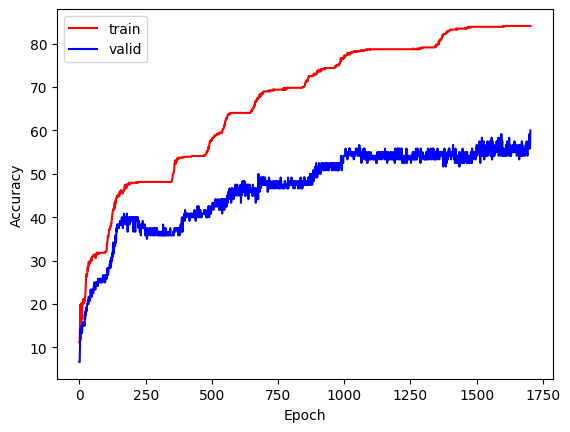

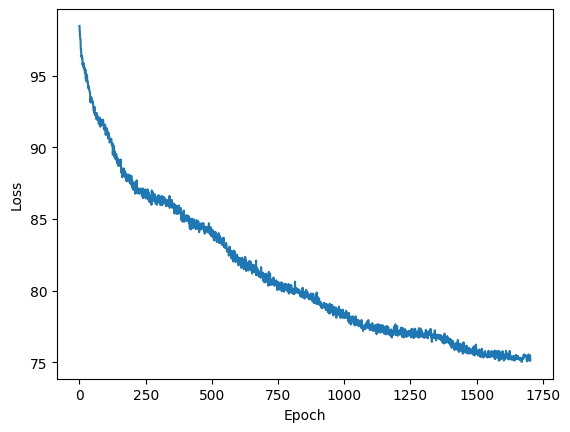

In [ ]:
# TRAINING BLOCK - Run multiple times to continue training.
num_epochs = 1000


# Start training loop
train_key_model(num_epochs)

print("loss: {}, train_acc: {}, valid_acc: {}".format(train_loss[-1], train_acc[-1], valid_acc[-1]))

# Plot graph of train and test accuracies over epochs
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_acc, "r")
plt.plot(valid_acc, "b")
plt.gca().legend(('train','valid'))
plt.show()

# Plot graph of training loss over epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

In [ ]:
print("loss: {}, train_acc: {}, valid_acc: {}".format(train_loss[-1], train_acc[-1], valid_acc[-1]))

loss: 75.12516713142395, train_acc: 84.0909090909091, valid_acc: 60.0


## **Mood Model training**

### Define model & Evaluation function

In [ ]:
class MoodModel(nn.Module):
    def __init__(self):

        super().__init__()

        # Fully connected layers
        self.fc_layers = nn.Sequential(nn.Linear(4800, 512),
                                       nn.Dropout(0.75),
                                       nn.ReLU(),

                                       nn.Linear(512, 2))

    def forward(self, x):

        # Process through fully connected layer
        x = self.fc_layers(x)

        return x

In [ ]:
from sklearn.metrics import r2_score

# Evaluation function to check r2 score accuracy from regression model
def evaluate(model, dataLoader):
  r2 = []

  # Good practice to turn on evaluate mode
  model.eval()

  with torch.no_grad():
    for data in dataLoader:

      inputs, labels = data
      inputs = inputs.to(device)
      outputs = model(inputs.float())

      r2.append(r2_score(labels, outputs.cpu(), multioutput='variance_weighted'))

  return np.mean(r2) * 100

### Define training block for **mood** regression

In [ ]:
# Training statistics storing block
# This allows to run the block below multiple times without losing info about previous epochs
# Run this block to reset them
mood_train_loss = []
mood_train_acc = []
mood_valid_acc = []

In [ ]:
# Determine device on which to run calculations
device = torch.device("cuda:0")


# Declare CNN network with 10 classes and send it to cuda device for computing
mood_model = MoodModel().to(device)

# Init. all of the model's weights using Xavier Uniform distribution.
mood_model.apply(weights_init)

# Use Mean Squared Error for regression problem
criterion = nn.MSELoss().to(device)


# Adam Optimizer, learning rate 0.0001 with weight decay to reduce overfitting (weight decay basically uses L2 regularization in pytorch for the adam optimizer)
optimizer = torch.optim.Adam(mood_model.parameters(), lr=1e-5, weight_decay=5e-3)

def train_mood_model(num_epochs):
  for epoch in range(num_epochs):

    running_loss = 0

    # Loop over batches
    for data in emo_train_dataloader:

      mood_model.train()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero the gradients and pass inputs through CNN
      optimizer.zero_grad()
      outputs = mood_model(inputs.float())

      # Compute loss
      loss = criterion(outputs, labels.float())

      # Compute gradients and update paramaters using optimizer's algorithm (Adam here)
      loss.backward()
      optimizer.step()

      # Add batch loss to this epoch's training loss
      running_loss += loss.item()

    # Append values to read later
    mood_train_loss.append(running_loss)
    mood_train_acc.append(evaluate(mood_model, emo_train_dataloader))
    mood_valid_acc.append(evaluate(mood_model, emo_valid_dataloader))

    if mood_valid_acc[-1] >= 60:
      print("Early stopping !!")
      break

    if (epoch % 10) == 0:
      print("Epoch {} loss: {}, train_acc: {}, valid_acc: {}".format(epoch+1, mood_train_loss[-1], mood_train_acc[-1], mood_valid_acc[-1]))


Epoch 1 loss: 25.40850070118904, train_acc: 76.0866109362462, valid_acc: 57.34447891080636
Epoch 11 loss: 25.23020476102829, train_acc: 77.06876893535943, valid_acc: 57.82064673631802
Epoch 21 loss: 25.32328552007675, train_acc: 74.18535903816196, valid_acc: 56.189859097591466
Epoch 31 loss: 25.11574500799179, train_acc: 73.36443577977465, valid_acc: 56.73234256175561
Epoch 41 loss: 25.086641311645508, train_acc: 76.17008820906692, valid_acc: 57.23395051113821
Epoch 51 loss: 26.112202525138855, train_acc: 76.43510416953467, valid_acc: 58.45745403109598
Early stopping !!


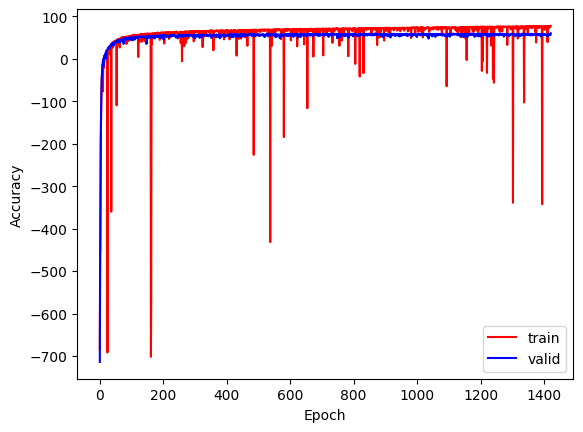

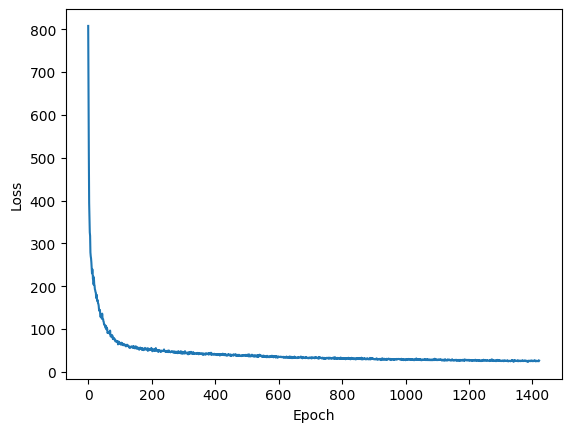

In [ ]:
# TRAINING BLOCK - Run multiple times to continue training.
num_epochs = 500


# Start training loop
train_mood_model(num_epochs)

# Plot graph of train and test accuracies over epochs
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(mood_train_acc, "r")
plt.plot(mood_valid_acc, "b")
plt.gca().legend(('train','valid'))
plt.show()

# Plot graph of training loss over epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(mood_train_loss)
plt.show()

In [ ]:
print("loss: {}, train_acc: {}, valid_acc: {}".format(train_loss[-1], train_acc[-1], valid_acc[-1]))

# **RECOMMENDERS**

## **Data Preparation**

### Load MTG-Jamendo data & build dictionary of tracks

In [ ]:
# Load jamendo data (4800 representations for 24492 songs) & their corresponding id to retrieve information
jamendo_data = np.load('/content/drive/MyDrive/Models/Datasets/MTG-Jamendo/jamendo_data.npy')
jamendo_ids = np.load('/content/drive/MyDrive/Models/Datasets/MTG-Jamendo/jamendo_ids.npy')

In [ ]:
# Unzip audio files for comparison evaluation
!unzip /content/drive/MyDrive/Models/Datasets/MTG-Jamendo/Audio1.zip -d /content/JamendoAudio
!unzip /content/drive/MyDrive/Models/Datasets/MTG-Jamendo/Audio2.zip -d /content/JamendoAudio
!unzip /content/drive/MyDrive/Models/Datasets/MTG-Jamendo/Audio3.zip -d /content/JamendoAudio
!unzip /content/drive/MyDrive/Models/Datasets/MTG-Jamendo/Audio4.zip -d /content/JamendoAudio

In [ ]:
tracks = {}

with open('/content/drive/MyDrive/Models/Datasets/MTG-Jamendo/CompleteTracks.json', encoding='utf-8') as file:
  tracks = json.load(file)


# All other features have already been organized in a dictionnary and saved inside a json to make loading easier.
# However, Jukebox representations are too large to be stored inside this json so we must retrieve them from its original numpy array
temp = {}

for track in tracks:
  # Skip tracks for which representations have not been processed
  if int(track) not in jamendo_ids:
    continue

  # Locate track index using id to get representations from data array
  index = np.where(jamendo_ids == int(track))[0][0]

  temp[track] = {'title': tracks[track]['title'],
                 'genre' : tracks[track]['genre'],
                 'duration' : float(tracks[track]['duration']),
                 'year' : int(tracks[track]['year']),
                 'key': tracks[track]['key'],
                 'valence': float(tracks[track]['valence']),
                 'arousal': float(tracks[track]['arousal']),
                 'representations' : jamendo_data[index] }

# Replace old dictionary to delete unused track entries and add representations
tracks = temp

print(tracks['0077441'])
print(tracks['0077441']['representations'].shape)
print(len(tracks))

{'title': 'Equinox', 'genre': ['chillout', 'electronic'], 'duration': 594.5, 'year': 2007, 'key': 1, 'valence': 4.7360888, 'arousal': 5.777613, 'representations': array([ 0.49287578,  0.16051039,  1.00152123, ..., -0.44382071,
        0.91370833,  0.57413268])}
(4800,)
24492


In [ ]:
# Convert dictionary to data frame to make processing a bit easier
tracks_dataset = pd.DataFrame.from_dict(tracks)

#print(list(dataset.loc['representations'][:10]))

## **Clustering experiments for 'k'**

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Standardize data
def standardize(x):
  x = (x - x.mean()) / x.std()
  return x


#X = list(dataset.loc['representations'])
#X = standardize(np.array(X))

k_max = 14

#### Elbow Method for KMeans

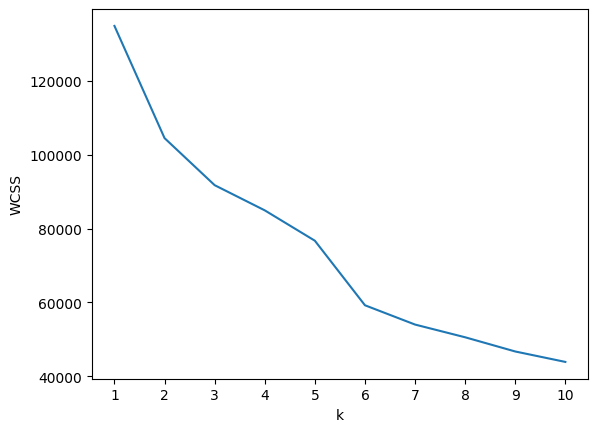

In [ ]:
#################
# USING K-MEANS #
#################

sse = []

for k in range(1, 11):
  kmeans = KMeans(n_clusters = k, n_init='auto').fit(scaled)
  centroids = kmeans.cluster_centers_
  pred = kmeans.predict(scaled)
  current_sse = 0

  for i in range(len(scaled)):
    current_center = centroids[pred[i]]

    for j in range(len(scaled[i])):
      current_sse += (scaled[i][j] - current_center[j]) ** 2

  sse.append(current_sse)

plt.xlabel("k")
plt.ylabel("WCSS")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.show()

#### BIC Method for GMM

In [ ]:
#############
# USING GMM #
#############

# Most of the code here is from the official sklearn documentation which includes a section about calculating BIC to optimize the GMM's parameters.
# Only the "full" covariance type is shown here but previous experiment was carried out with all covariance types to determine the best

def gmm_bic_score(estimator, X):
  # Make it negative since GridSearchCV expects a score to maximize
  return -estimator.bic(X)

param_grid = {
    "n_components": range(10, 21),
    "covariance_type": ["full"],
}

scaler = StandardScaler()
scaled = scaler.fit_transform(X)

grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score, verbose=1)
grid_search.fit(scaled)



df = pd.DataFrame(grid_search.cv_results_)[["param_n_components", "param_covariance_type", "mean_test_score"]]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
        }
    )

df.sort_values(by="BIC score").head()

Fitting 5 folds for each of 11 candidates, totalling 55 fits


,Number of components,Type of covariance,BIC score
7,17,full,26630.038822
6,16,full,27437.812585
5,15,full,27616.241892
1,11,full,28013.825577
3,13,full,28236.764610


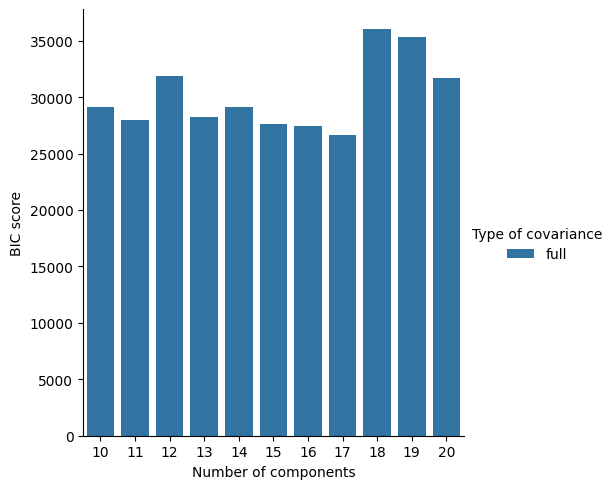

In [ ]:
import seaborn as sns

df = pd.DataFrame(grid_search.cv_results_)[["param_n_components", "param_covariance_type", "mean_test_score"]]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
        }
    )

df.sort_values(by="BIC score").head()

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In [ ]:
plt.xlabel("k")
plt.ylabel("BIC Score")
plt.plot(range(10, 21), [-1.038160e+8, -1.053443e+8, -1.061264e+8, -1.065867e+8, -1.070856e+8, -1.073299e+8, -1.075297e+8, -1.076979e+8, -1.077725e+8, -1.078453e+8, -1.078818e+8, -1.07967e+8, -1.080025e+8, -1.080061e+8])
plt.xticks(range(1, 15))
plt.show()

#### Silhouette Method for KMeans

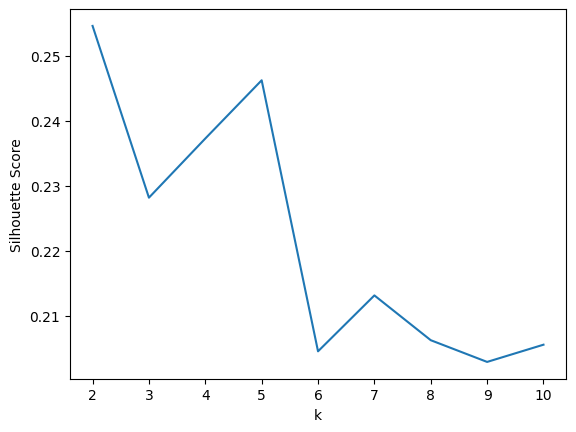

In [ ]:
score = []

for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, n_init='auto').fit(scaled)
  pred = kmeans.predict(scaled)
  score.append(silhouette_score(scaled, pred, metric='euclidean'))

plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.plot(range(2, 11), score)
plt.xticks(range(2, 11))
plt.show()

## **Recommender tests**

In [ ]:
# Create training set by removing 2000 test songs
split = np.load('/content/drive/MyDrive/Models/Datasets/MTG-Jamendo/Split2000.npy')

train_tracks = {}

# Remove tracks used in the test split
for track in tracks:
  if int(track) not in split:
    train_tracks[track] = tracks[track]

# Different dictionaries used to process the recommendations
dataset = pd.DataFrame.from_dict(train_tracks)
tracks_dataset = pd.DataFrame.from_dict(tracks)
loc_dataset = tracks_dataset.loc['title'] # Only used to locate the index of a particular song in the dataset instead of its id
feature_dataset = np.zeros((22492, 6))

# ----------------------------------------------------------
# Convert genre tags to binary and then to decimal (this can take a while considering there are 95 genre tags)

# A better way could very probably be found but 2 genre datasets are needed, one for the feature
complete_genre = tracks_dataset.loc['genre']
mlb = MultiLabelBinarizer()

labels = mlb.fit_transform(complete_genre)

complete_genres = []
for b in labels:
  complete_genres.append(sum(val*(2**idx) for idx, val in enumerate(reversed(b))))

genre_dataset = np.array(complete_genres)

# For a different dataset
genre = dataset.loc['genre']

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(genre)

# Convert binaries to decimals (the long part)
genres = []
for b in labels:
  genres.append(sum(val*(2**idx) for idx, val in enumerate(reversed(b))))
# ----------------------------------------------------------

dura = np.array(list(dataset.loc['duration']))
year = np.array(list(dataset.loc['year']))
key = np.array(list(dataset.loc['key']))
val = np.array(list(dataset.loc['valence']))
arou = np.array(list(dataset.loc['arousal']))
genres = np.array(genres)

for i in range(len(dura)):
  feature_dataset[i] = np.array([dura[i], year[i], key[i], val[i], arou[i], genres[i]])

### Multilabel Binarizer Tests (ignore)

In [ ]:
# These code blocks were only to test and understand how to manage the multilabel binarizer

genre = dataset.loc['genre']
mlb = MultiLabelBinarizer()

labels = mlb.fit_transform(genre)

genres = []
for b in labels:
  genres.append(sum(val*(2**idx) for idx, val in enumerate(reversed(b))))

dura = np.array(list(dataset.loc['duration']))
year = np.array(list(dataset.loc['year']))
key = np.array(list(dataset.loc['key']))
val = np.array(list(dataset.loc['valence']))
arou = np.array(list(dataset.loc['arousal']))
genres = np.array(genres)

In [ ]:
complete_genre = tracks_dataset.loc['genre']
mlb = MultiLabelBinarizer()

labels = mlb.fit_transform(complete_genre)

complete_genres = []
for b in labels:
  complete_genres.append(sum(val*(2**idx) for idx, val in enumerate(reversed(b))))

complete_genres = np.array(complete_genres)

In [ ]:
X = np.zeros((22492, 6))
for i in range(len(dura)):
  X[i] = np.array([dura[i], year[i], key[i], val[i], arou[i], genres[i]])

### Clustering training

In [ ]:
#################
# K-Means Model #
#################

# Models used to be trained on a value called X that was previously defined as the tracks's training dataset part.
# However, once I was done with training and started working on the API implementation, I sorted a lot of the code and chose (arguably) better variable names.
# Later on, since the initialization code from the API was cleaner, I moved it inside the colab and hence lost some variables that I wasn't using anymore, including X.

kmean_model = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=5, verbose=2))], verbose=True)
#X = list(dataset.loc['representations']) # To train only on representations
kmean_model.fit(X)

In [ ]:
#############
# GMM Model #
#############

gmm_model = Pipeline([('scaler', StandardScaler()), ('gmm', GaussianMixture(n_components=17, covariance_type='full', verbose=2))], verbose=True)
#X = list(dataset.loc['representations']) # To train only on representations
gmm_model.fit(X)

In [ ]:
from joblib import dump

# Save model
dump(gmm_model, 'Features_GMM_Model.joblib')

['Features_GMM_Model.joblib']

In [ ]:
from joblib import load

# Load models
reps_gmm_model = load('/content/drive/MyDrive/Models/Datasets/MTG-Jamendo/Reps_GMM_Model.joblib')
features_gmm_model = load('/content/drive/MyDrive/Models/Datasets/MTG-Jamendo/Feature_GMM_Model.joblib')

### Recommender testing

In [ ]:
#################
# Testing block #
#################

# THIS ISN'T FOR EVALUATION, ONLY TESTING
# This block is mostly taken from the API implementation
# Real testing can be carried out at https://muse.augustindirand.com

track_ids = ['1410138', '0082808', '1415940']
n_songs = 5

# ---- Using Representations ---------------
centers = []
for input in track_ids:
  centers.append(tracks_dataset[input]['representations'])

song_center = np.mean(np.array(centers), axis=0)

scaler = reps_gmm_model.steps[0][1]
scaled_data = scaler.transform(list(dataset.loc['representations']))
scaled_song_center = scaler.transform(song_center.reshape(1, -1))


dist = cosine_similarity(scaled_song_center, scaled_data)

index = list(np.argsort(dist)[:,:n_songs][0])

reps_recs = []

print("---- Reps ----")
for idx in index:
  rec_id = str(list(tracks_dataset)[idx])
  print(tracks[rec_id]['title'])

# ---- Using Features ----------------------
centers = []
for input in track_ids:
  song_idx = loc_dataset.index.get_loc(input)
  center = np.array([tracks_dataset.loc['duration'][input], tracks_dataset.loc['year'][input],
                     tracks_dataset.loc['key'][input], tracks_dataset.loc['valence'][input],
                     tracks_dataset.loc['arousal'][input], genre_dataset[song_idx]])
  centers.append(center)

song_center = np.mean(np.array(centers), axis=0)

scaler = features_gmm_model.steps[0][1]
scaled_data = scaler.transform(feature_dataset)
scaled_song_center = scaler.transform(song_center.reshape(1, -1))


dist = cosine_similarity(scaled_song_center, scaled_data)

index = list(np.argsort(dist)[:,:n_songs][0])

feature_recs = []

print("\n---- Features ----")
for idx in index:
  rec_id = str(list(tracks_dataset)[idx])
  print(tracks[rec_id]['title'])

### Recommender evaluation

In [ ]:
"""
# Normalize similarity score based on local experiments
def norma(x):
  return (x - 0.02) / (0.2537313432835821 - 0.02)
"""

# Similarity score calculation based on zip sizes (and reference [31] from my report)
def sim_score(x1, x2):
  track_0 = '/content/JamendoAudio/'+str(x1)+'.low.mp3'
  track_1 = '/content/JamendoAudio/'+str(x2)+'.low.mp3'

  Cx1 = len(gzip.compress(track_0.encode()))
  Cx2 = len(gzip.compress(track_1.encode()))

  x1x2 = " ".join([track_0, track_1])
  Cx1x2 = len(gzip.compress(x1x2.encode()))

  score = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

  return score


loc_dataset = tracks_dataset.loc['title']
####################
# Evaluation block #
####################
n_songs = 3
score = []

for track_id in split:
  input_track = "{:07d}".format(int(track_id))

  song_idx = loc_dataset.index.get_loc(input_track)
  song_center = np.array([tracks_dataset.loc['duration'][input_track], tracks_dataset.loc['year'][input_track],
                          tracks_dataset.loc['key'][input_track], tracks_dataset.loc['valence'][input_track],
                          tracks_dataset.loc['arousal'][input_track], complete_genres[song_idx]])
  #song_center = tracks_dataset[input_track]['representations']

  scaler = kmean_model.steps[0][1]
  scaled_data = scaler.transform(X)
  scaled_song_center = scaler.transform(song_center.reshape(1, -1))


  dist = cosine_similarity(scaled_song_center, scaled_data)

  index = list(np.argsort(dist)[:,:n_songs][0])

  loc_score = []

  for idx in index:
    rec_id = str(list(tracks_dataset)[idx])
    loc_score.append(sim_score(track_id, int(rec_id)))

  score.append(np.mean(np.array(loc_score)))

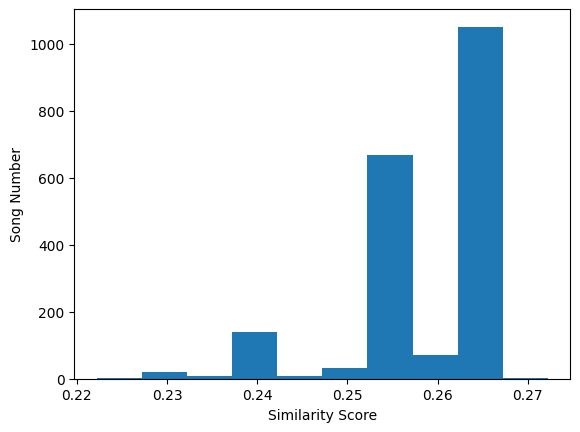

In [ ]:
counts, bins = np.histogram(score)

plt.xlabel("Similarity Score")
plt.ylabel("Song Number")
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [ ]:
print("Max: {}".format(max(score)))
print("\nMin: {}".format(min(score)))
print("\nAvg: {}".format(np.mean(np.array(score))))

Max: 0.2722222222222222

Min: 0.2222222222222222

Avg: 0.25962900043064996
